| Input features                              | Num basis | Regularizer       | Train loss         | Val loss           | Trained on Train+Val, Test loss |  Past test loss  | Remark
|-------------------------------------|-----------|-------------------|--------------------|--------------------|---------------------------------|---|  ----|
| $p$, $U:2$                                  | 15        | 4183.673469387755 | 168.73394113815039 | 201.71884028821677 | 137.14877428798286     | 455.61986895953567   478.81477974255034    483.8987597939727  | means of prediction is around 0
| $p$, $U:0$, $U:1$, $U:2$                    |           |                   |                    |                    |                                 |  |  |
| $p$, $U:0$, $U:1$, $U:2$, $k$               |           |                   |                    |                    |                                 |  |  |
| $p$, $U:0$, $U:1$, $U:2$, $k$, $\omega$      |           |                   |                    |                    |                                 |  |  |
| $p$, $U:0$, $U:1$, $U:2$, $k$, nut, $\omega$ |           |                   |                    |                    |                                 |  |  |

In [43]:
import rom_operator_inference as opinf

import pickle
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import traceback
import itertools

from tqdm.notebook import tqdm
import warnings
from scipy.integrate import IntegrationWarning
from scipy.linalg import LinAlgWarning

In [2]:
# !pip install git+https://github.com/Willcox-Research-Group/rom-operator-inference-Python3.git

In [3]:
# Matplotlib customizations.
plt.rc("figure", dpi=300, figsize=(9,3))
plt.rc("font", family="serif", size=6)
plt.rc("legend", edgecolor='none')

In [4]:
chosen_columns = ['p', 'U:0', 'U:1', 'U:2']  # check absolute value other U:0, U:1 (done in 01_data_transform.ipynb)
sets = ['train', 'val', 'test']

input_files = [(dataset, column) for dataset in sets for column in chosen_columns]

In [5]:
input_files

[('train', 'p'),
 ('train', 'U:2'),
 ('val', 'p'),
 ('val', 'U:2'),
 ('test', 'p'),
 ('test', 'U:2')]

In [6]:
tables = {}
for i in input_files:
    with open(f'{i[0]}_{i[1]}.pkl', 'rb') as f:        
        tables[f'{i[0]}_{i[1]}'] = pickle.load(f)

## Plotting the mean pressure and speed

In [7]:
import pandas as pd
v_inlet_bc = pd.read_csv("v_inlet_bc.csv")

In [8]:
tables['train_p']

array([[ 3.5176e+03,  8.0626e+01,  4.2379e+01, ...,  3.4691e+03,
         3.1394e+03,  3.4567e+03],
       [ 4.8551e+02,  5.6927e+00,  3.0672e+00, ...,  4.8197e+02,
         4.3094e+02,  4.8102e+02],
       [ 4.5713e+02,  5.7872e+00,  3.1071e+00, ...,  4.5353e+02,
         4.0197e+02,  4.5255e+02],
       ...,
       [ 2.8777e+00, -1.0637e+00, -5.4266e-01, ...,  3.3313e+00,
        -4.4804e+00,  3.3647e+00],
       [ 2.3595e+00, -1.0542e+00, -5.4202e-01, ...,  2.8224e+00,
        -4.2974e+00,  2.8618e+00],
       [ 8.4368e-01, -1.0536e+00, -5.3081e-01, ...,  1.3165e+00,
        -4.9449e+00,  1.3602e+00]])

In [9]:
tables['train_p'].shape
# check if mean is dominant, plot eigen values and eigen vectors of the PCA.
# Plot eigen values see if decrease
# OR plot the sum of eigen values
# if increase the number of eigen values, "energy" is increase s.t we perserve the system
# cumulative e. preservation Sum of eigen / sum of all of eigen
# done, see below

(499, 7582)

In [10]:
DELTA_T = 2e-3 # step of a time
MAX_T = 2

According to the https://github.com/Willcox-Research-Group/rom-operator-inference-Python3/blob/main/docs/content/tutorials/basics.ipynb, the matrix must be `space` $\times$ `time`

In [11]:
for t in tables:
    tables[t] = tables[t].T

In [12]:
assert tables['train_p'].shape[0] > tables['train_p'].shape[1]   # space is larger than time

In [13]:
all_pressures = np.concatenate([tables['train_p'], tables['val_p'], tables['test_p']],axis=1)
all_pressures.shape

(7582, 999)

In [14]:
all_pressures_mean = all_pressures.mean(0)

In [15]:
tables['train_p'].shape

(7582, 499)

In [16]:
all_pressures_mean.shape

(999,)

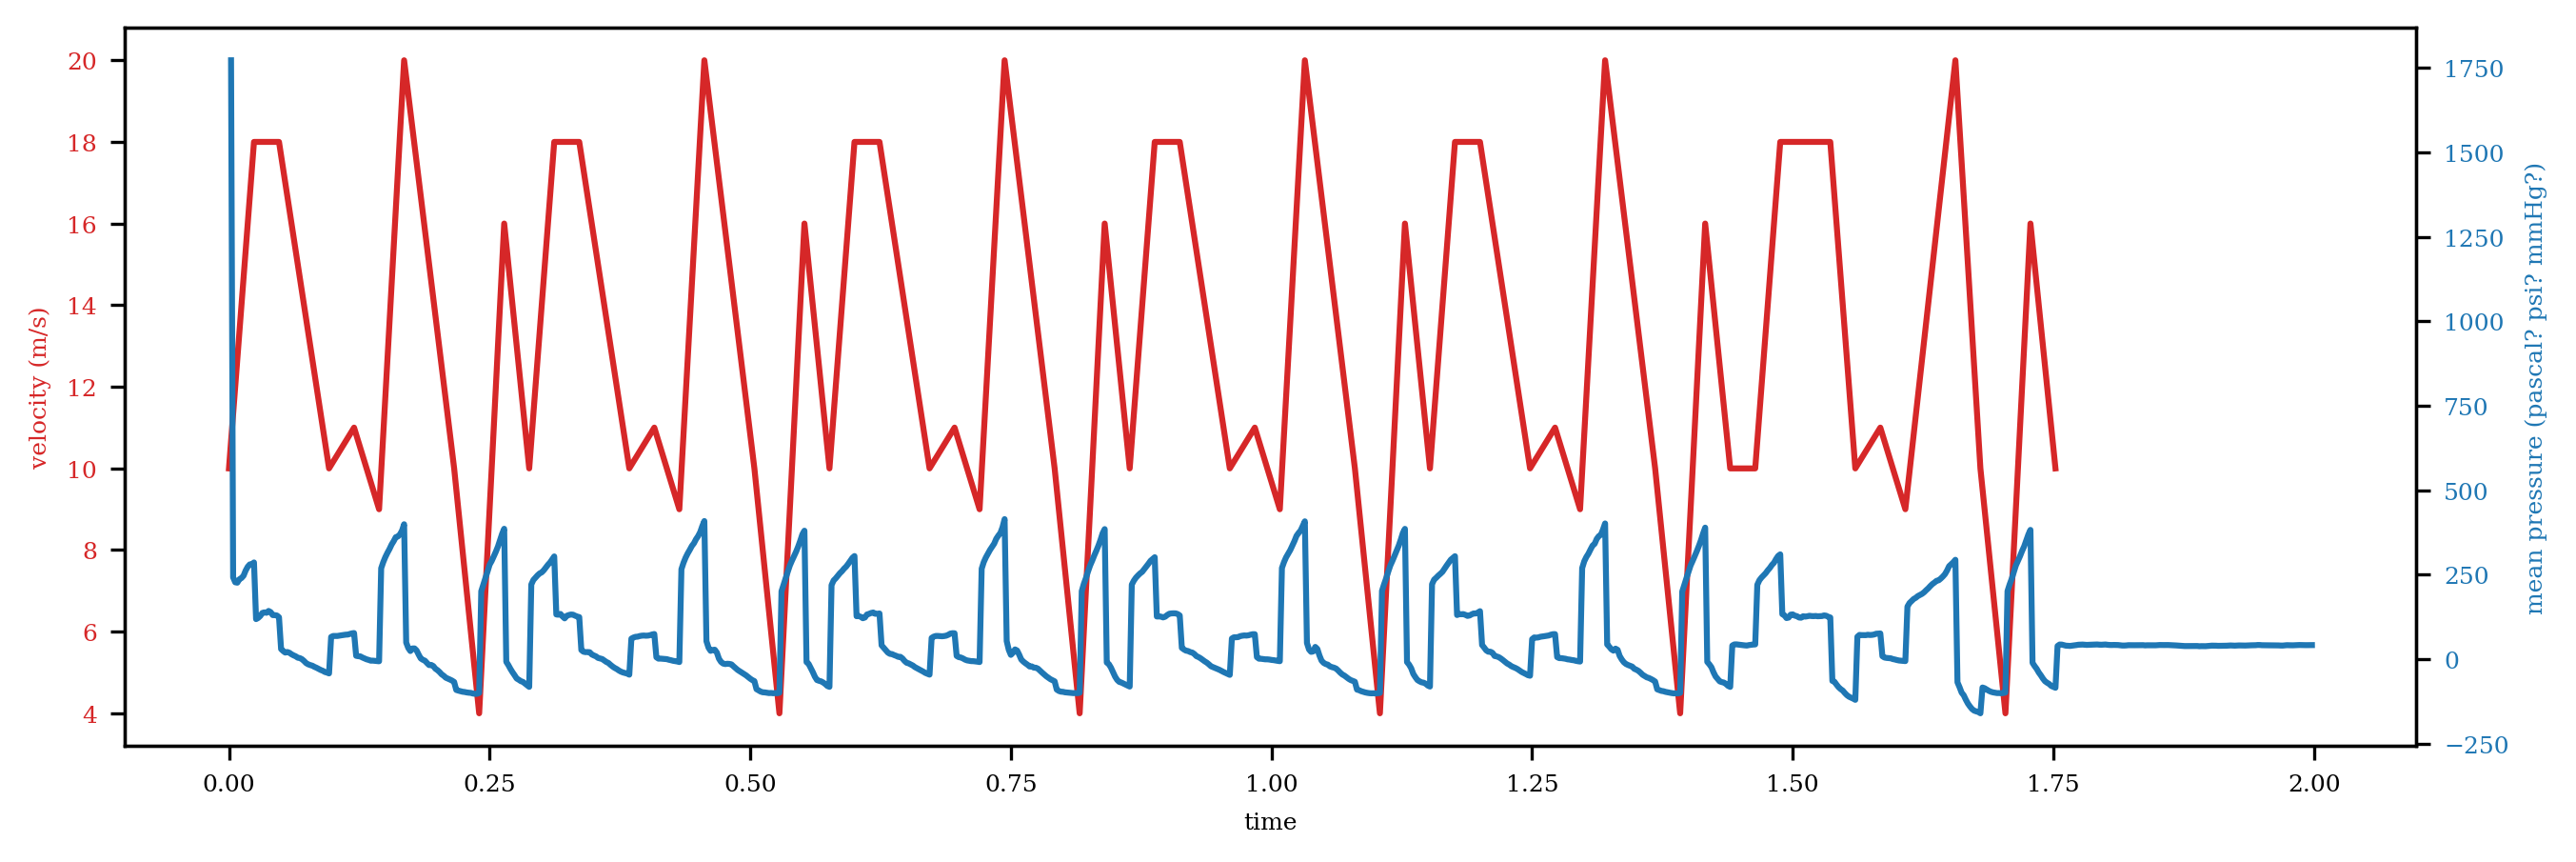

In [17]:
fig, ax1 = plt.subplots()
x1 = np.arange(DELTA_T, MAX_T, DELTA_T)

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('velocity (m/s)', color=color)
ax1.plot(v_inlet_bc['t'], v_inlet_bc['Uz'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('mean pressure (pascal? psi? mmHg?)', color=color)
ax2.plot(x1, all_pressures_mean)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

# todo ignore the 1st step of data

# for future, BC as a forcing term

Due to the strange outlier in 1st frame of pressure, we will ignore it

In [18]:
# discard the first data point for train
for i in chosen_columns:
    tables[f'train_{i}'] = tables[f'train_{i}'][:,1:]

## Scale and stack data

Scale separately for each feature, s.t they have 0 mean, 1 std. Then stacking `[rho_0, v_0, rho_1, v_1, … , rho_n, v_n]` to a `train_data`. The shape would be (`space` $\times$ `num_ft`, `time`)

$
\begin{bmatrix} p_{1,1} & p_{1,2} & \cdots & p_{1,n} \\ 
p_{2,1} & p_{2,2} & \cdots & p_{1,n} \\ 
\vdots & \vdots & \vdots & \vdots \\ 
p_{m,1} & p_{m,2} & \cdots & p_{m,n} \end{bmatrix}
$
$
\begin{bmatrix} U:2_{1,1} & U:2_{1,2} & \cdots & U:2_{1,n} \\ 
U:2_{2,1} & U:2_{2,2} & \cdots & U:2_{1,n} \\ 
\vdots & \vdots & \vdots & \vdots \\ 
U:2_{m,1} & U:2_{m,2} & \cdots & U:2_{m,n} \end{bmatrix}
$
$
\rightarrow
$
$
\begin{bmatrix} k_{1,1} & k_{1,2} & \cdots & nut_{1,n} \\ nut_{1,1} & k_{1,2} & \cdots & nut_{1,n} \\ \omega_{1,1} & \omega_{1,2} & \cdots & \omega_{1,n} \\  p_{1,1} & p_{1,2} & \cdots & p_{1,n} \\  U:0_{1,1} & U:0_{1,2} & \cdots & U:0_{1,n} \\  U:1_{1,1} & U:1_{1,2} & \cdots & U:1_{1,n} \\  U:2_{1,1} & U:2_{1,2} & \cdots & U:2_{1,n} \\ \vdots & \vdots & \vdots & \vdots \\ U:2_{m,1} & U:2_{m,2} & \cdots & U:2_{m,n} \end{bmatrix}  (1)
$

with $m$ is space and $n$ is time (https://github.com/Willcox-Research-Group/rom-operator-inference-Python3/issues/30)

### Normalize data

In [19]:
def normalize(timeframes, max_ft = None, min_ft = None):
    '''
    At t=0, get the mean and std through spacial dimension
    '''
    if max_ft is not None and min_ft is not None:
        scaled = (timeframes - min_ft) / (max_ft - min_ft)
        return scaled
    max_ft = timeframes.max(1).reshape((timeframes.shape[0], 1))
    min_ft = timeframes.min(1).reshape((timeframes.shape[0], 1))
    for i in range(max_ft.shape[0]):
        if max_ft[i] == min_ft[i]:
            max_ft[i] += 1  # so that (x - min_ft[i]) / (max_ft[i] - min_ft[i]) = (x - min_ft[i]) / 1, to avoid div by 0
    scaled = (timeframes - min_ft) / (max_ft - min_ft)
    return scaled, max_ft, min_ft

In [20]:
# test normalize
data = np.array([[-1. ,  2. ], [-0.5,  6. ], [ 0. , 10. ], [ 1. , 18. ]])
normed_data, max_ft, min_ft = normalize(data)
print(f"{max_ft} \n {min_ft} \n {normed_data}")
print(normalize([[100], [100], [100], [100]], max_ft, min_ft))

[[ 2.]
 [ 6.]
 [10.]
 [18.]] 
 [[-1. ]
 [-0.5]
 [ 0. ]
 [ 1. ]] 
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[33.66666667]
 [15.46153846]
 [10.        ]
 [ 5.82352941]]


In [21]:
normed_data, max_ft, min_ft = {}, {}, {}
for key in tables:
    if key.startswith('train'):
        normed_data[key], max_ft[key], min_ft[key] = normalize(tables[key])

### Stack data

In [22]:
def stack_data(tables_to_stack, set_name):
    if set_name not in('train', 'val', 'test'):
        raise ValueError
    data = []
    for row in range(tables_to_stack[f'{set_name}_p'].shape[0]):
        for i in tables_to_stack:
            if i.startswith(set_name):
                data.append(tables_to_stack[i][row])
    data = np.array(data)
    print("After stacking shape: ", data.shape)
    assert len(data) == sum([len(tables_to_stack[t]) for t in tables_to_stack if t.startswith(set_name)])  # train_data long as concat of all tables
    return data

In [23]:
# test stack_data
# tr_p_11: train p at space 1 time 1
test_table = {'train_p': np.array([['tr_p_11', 'tr_p_12'], ['tr_p_21', 'tr_p_22']]), 
              'train_u': np.array([['tr_u_11', 'tr_u_12'], ['tr_u_21', 'tr_u_22']]),
              'val_p': np.array([['va_p_11', 'va_p_12'], ['va_p_21', 'va_p_22']]), 
              'val_u': np.array([['va_p_11', 'va_p_12'], ['va_p_21', 'va_p_22']])}
expected_result = np.array([['tr_p_11', 'tr_p_12'], ['tr_u_11', 'tr_u_12'], 
                            ['tr_p_21', 'tr_p_22'], ['tr_u_21', 'tr_u_22']])
assert (stack_data(test_table, 'train') == expected_result).all()
expected_result

After stacking shape:  (4, 2)


array([['tr_p_11', 'tr_p_12'],
       ['tr_u_11', 'tr_u_12'],
       ['tr_p_21', 'tr_p_22'],
       ['tr_u_21', 'tr_u_22']], dtype='<U7')

In [24]:
def unstack_data(array, ft, list_of_fts):
    # find the order $o$ of `ft` in `list_of_fts`
    # then extract every $o$th row, starting from the first $o$th row, not 0
    assert len(array.shape) == 2
    index = list_of_fts.index(ft)
    return array[np.arange(index, array.shape[0], len(list_of_fts)),:]

In [25]:
test_arr = np.array([['u11', 'u12', 'u13'], ['v11', 'v12', 'v13'], ['p11', 'p12', 'p13'], 
                     ['u21', 'u22', 'u23'], ['v21', 'v22', 'v23'], ['p21', 'p22', 'p23']])
assert (unstack_data(test_arr, 'u', ['u', 'v', 'p']) == np.array([['u11', 'u12', 'u13'], ['u21', 'u22', 'u23']])).all()  # a: 1st element, sample every 1
assert (unstack_data(test_arr, 'v', ['u', 'v', 'p']) == np.array([['v11', 'v12', 'v13'], ['v21', 'v22', 'v23']])).all()  # b: 2nd element, sample every 2
assert (unstack_data(test_arr, 'p', ['u', 'v', 'p']) == np.array([['p11', 'p12', 'p13'], ['p21', 'p22', 'p23']])).all()  # c: 3rd element, sample every 3

In [26]:
def prepare_data_and_train(data_to_train, r, regularizer=1e6):
    train_data_derivative = opinf.pre.ddt(data_to_train, DELTA_T, order=6)        # Calculate the time derivative matrix.
    Vr, _ = opinf.pre.pod_basis(data_to_train, r)
    rom = opinf.ContinuousOpInfROM(modelform="cAH")   # todo add quadratics cA is just DMD https://github.com/Willcox-Research-Group/rom-operator-inference-Python3/blob/dad3b6588708c2a4d600491ebd936165a76968ca/src/rom_operator_inference/core/nonparametric/_public.py#L217
    rom.fit(Vr, data_to_train, train_data_derivative, regularizer=regularizer)
    return rom

In [27]:
def post_process(prediction, max_ft, min_ft):
    scaled_predicted_p = unstack_data(prediction, 'p', chosen_columns)
    predicted_p = (scaled_predicted_p * (max_ft - min_ft)) + min_ft
    return predicted_p

### Create train data

In [28]:
# stack data
train_data = stack_data(normed_data, 'train')  # todo no stack yet
for i, column in enumerate(chosen_columns):
    assert (train_data[i] == normed_data[f'train_{column}'][0]).all()
    
assert (train_data[0,:] == normed_data['train_p'][0,:]).all()
assert (train_data[1,:] == normed_data['train_U:2'][0,:]).all()

After stacking shape:  (15164, 498)


In [29]:
start_prediction = (tables['train_p'].shape[1] + 1 + 1) * DELTA_T  # 1 for skipping one at the beginning, 1 for the frame after last frame
end_prediction = (tables['train_p'].shape[1] + tables['val_p'].shape[1] + 1 + 1) * DELTA_T
print(start_prediction, end_prediction)

1.0 1.198


In [30]:
tables['val_p'].shape

(7582, 99)

In [31]:
np.arange(start_prediction, end_prediction, DELTA_T).shape

(99,)

## Choosing number of basis

### Exploration

In [32]:
import scipy.linalg as la

svdvals = la.svdvals(train_data)
svdvals

array([1.29108467e+03, 4.51623373e+02, 6.51259498e+01, 4.30985877e+01,
       2.66017140e+01, 2.02739570e+01, 1.87429917e+01, 1.42089322e+01,
       1.38290333e+01, 1.37035344e+01, 1.02992512e+01, 9.75220323e+00,
       8.75346652e+00, 8.43318932e+00, 8.05301345e+00, 7.52729416e+00,
       7.36430181e+00, 6.52940222e+00, 6.14834579e+00, 5.67977961e+00,
       5.55095847e+00, 5.25152970e+00, 5.09036583e+00, 5.05654037e+00,
       4.62411730e+00, 4.39490413e+00, 4.11607097e+00, 4.07519913e+00,
       3.99873499e+00, 3.64102119e+00, 3.54510252e+00, 3.41236381e+00,
       3.36549136e+00, 3.33042339e+00, 3.04415320e+00, 3.00201474e+00,
       2.98619561e+00, 2.89100894e+00, 2.74401264e+00, 2.68032144e+00,
       2.65385429e+00, 2.60371527e+00, 2.47351285e+00, 2.41819530e+00,
       2.36558879e+00, 2.35238033e+00, 2.24212338e+00, 2.18869025e+00,
       2.18152208e+00, 2.10627049e+00, 2.07987703e+00, 2.04979036e+00,
       1.98303134e+00, 1.96244956e+00, 1.90623194e+00, 1.85272020e+00,
      

498

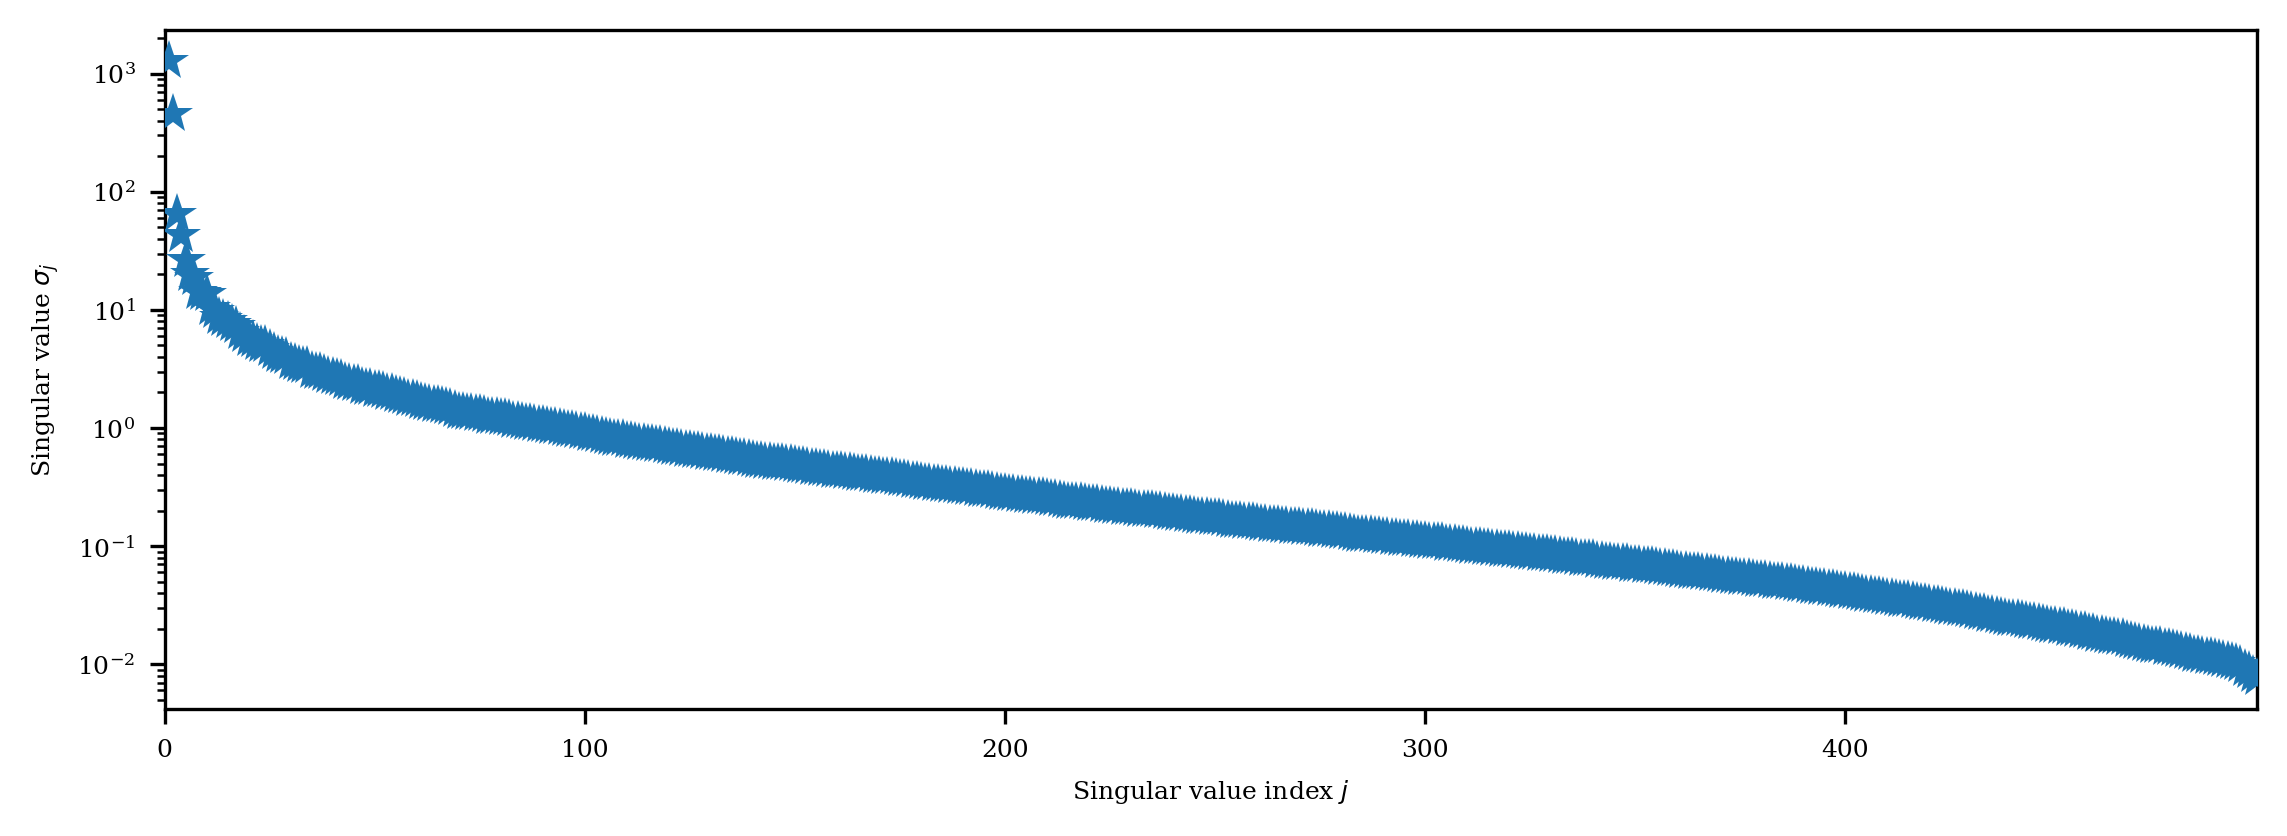

In [33]:
opinf.pre.svdval_decay(svdvals, 1e-3, plot=True)

In [34]:
r = opinf.pre.cumulative_energy(svdvals, .999, plot=False)
print(f"r = {r}")
r = opinf.pre.cumulative_energy(svdvals, .9996, plot=False)
print(f"r = {r}")
r = opinf.pre.cumulative_energy(svdvals, .9999, plot=False)
print(f"r = {r}")

r = 7
r = 15
r = 40


Fitting `r` as 15

In [35]:
r = 15
Vr, _ = opinf.pre.pod_basis(train_data, r, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (15164, 15)


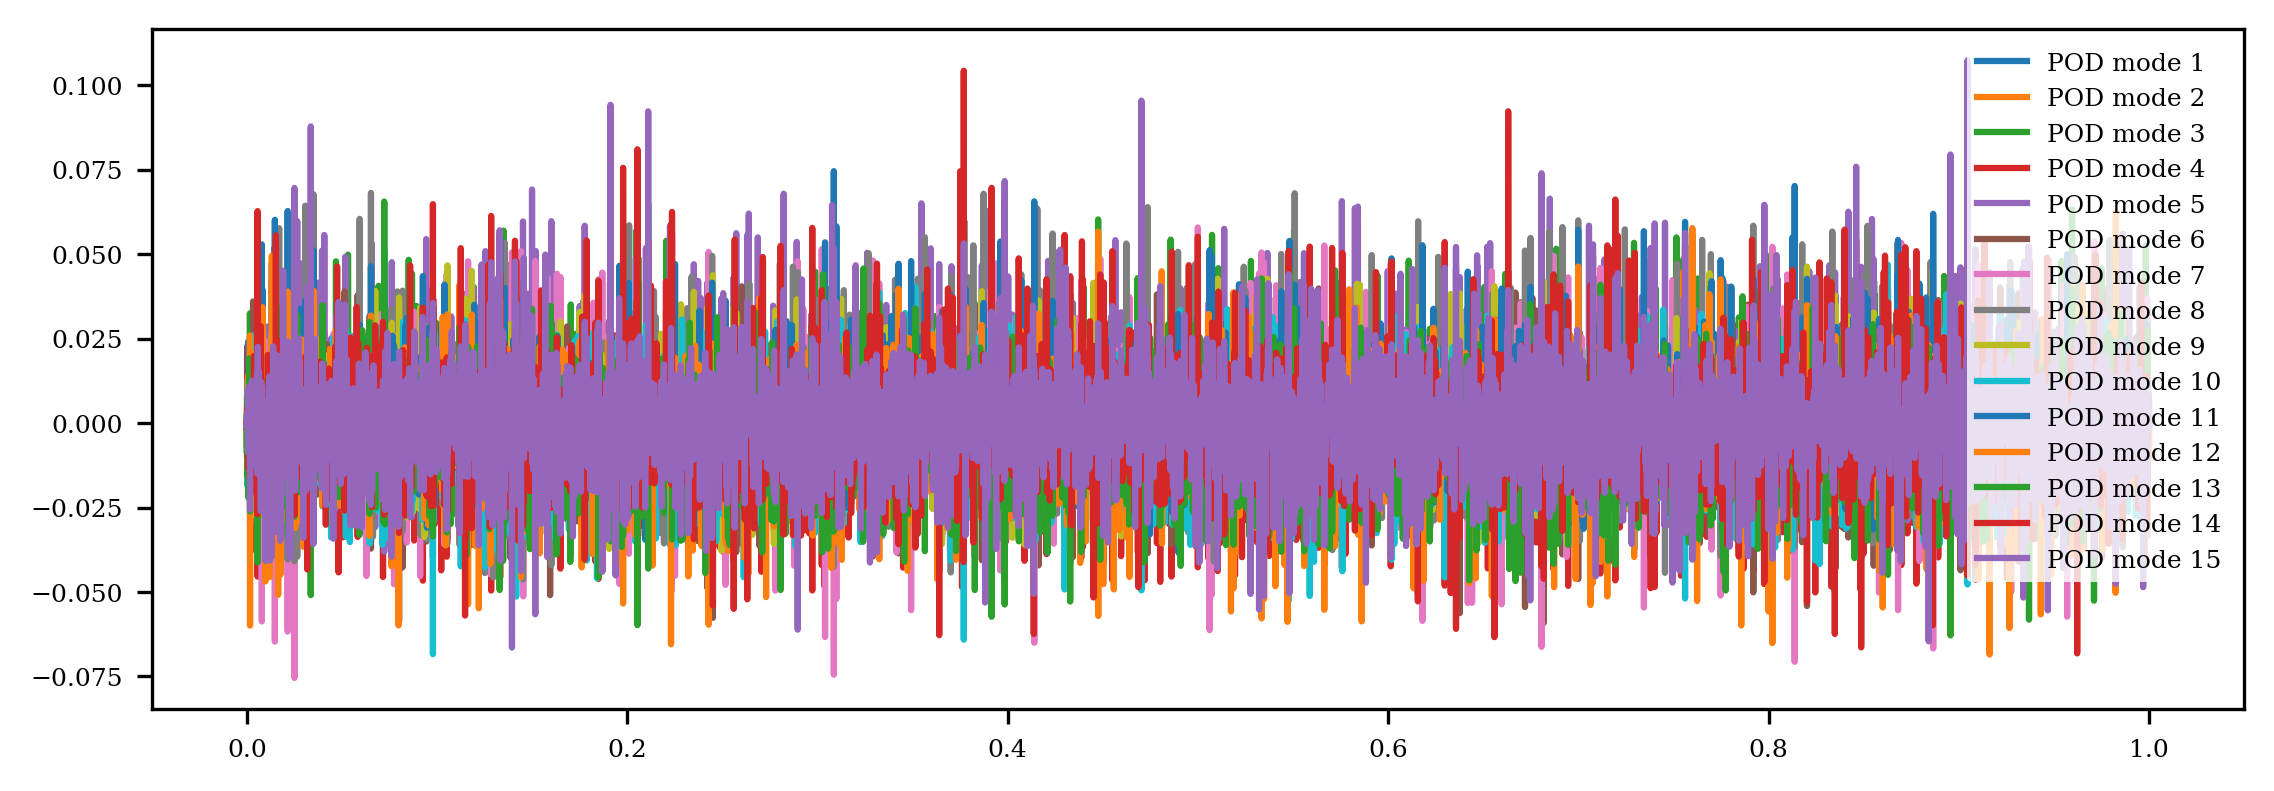

In [36]:
# Visualize those pod
for j in range(Vr.shape[1]):    
    plt.plot(np.linspace(0, 1, Vr.shape[0]+2), np.concatenate(([0], Vr[:,j], [0])), label=f"POD mode {j+1}")
plt.legend(loc="upper right")
plt.show()

### Test number of basis

In [60]:
test_data.shape

(15164, 401)

In [59]:
pca.inverse_transform(reduced_data).shape

(15164, 498)

In [61]:
# on train
pca = PCA(n_components=r).fit(train_data)
reduced_data = pca.transform(train_data)
reconstructed_data = pca.inverse_transform(reduced_data)
print("Train reconstruction loss: ", mse(reconstructed_data, train_data))

# on test, with same r, should have similar loss, to make sure there is no distribution shift
for key in tables:
    if key.startswith('test'):
        normed_data[key], max_ft[key], min_ft[key] = normalize(tables[key])
test_data = stack_data(normed_data, 'test')
pca_test = PCA(n_components=r).fit(test_data)
reduced_data = pca_test.transform(test_data)
reconstructed_data = pca_test.inverse_transform(reduced_data)
print("Test reconstruction loss: ", mse(reconstructed_data, test_data))

Train reconstruction loss:  9.554631476617612e-05
After stacking shape:  (15164, 401)
Test reconstruction loss:  7.234754645628562e-05


No big difference in test and train data, with same `r`

## Train, test on val

In [37]:
def train_and_plot(regularizer_range, r):
    regularizers, val_losses, train_losses = [], [], []
    for regularizer in tqdm(regularizer_range):
        rom = prepare_data_and_train(train_data, r=r, regularizer=regularizer)
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                prediction = rom.predict(train_data[:,-1], np.arange(start_prediction, end_prediction, DELTA_T), method='Radau')   # predict from the last column of train data        
                # prediction is for multiple variable in chosen_colums. We only care about `p`. 
                # Therefore we are going to extract p from it
                predicted_p = post_process(prediction, max_ft['train_p'], min_ft['train_p'])
                val_loss = mse(predicted_p , tables['val_p'], squared=False)   
                sanity_check = rom.predict(train_data[:,0], np.arange(DELTA_T, start_prediction- DELTA_T, DELTA_T))
                sanity_check = post_process(sanity_check, max_ft['train_p'], min_ft['train_p'])
                train_loss = mse(sanity_check , tables['train_p'], squared=False)
                print(regularizer, train_loss, val_loss)
                regularizers.append(regularizer)
                val_losses.append(val_loss)
                train_losses.append(train_loss)
            except IntegrationWarning:
                print(f'regularizer={regularizer}, integration error happens')
            except LinAlgWarning:
                print(f'regularizer={regularizer}, unterdetermined system')
    return regularizers, train_losses, val_losses

In [38]:
regularizers, train_losses, val_losses = train_and_plot(np.linspace(1e3, 5e4), 15)

  0%|          | 0/50 [00:00<?, ?it/s]

1000.0 531.8763045131401 272.6159405629088
2000.0 191.14914247289954 226.37685539106204
3000.0 171.65462386815005 209.6391920958572
4000.0 164.11956062991953 201.99302028569585
5000.0 165.5192139392763 207.75389565720994
6000.0 174.27104626800596 219.248170389437
7000.0 179.51505678779026 230.00190764414486
8000.0 192.1385471670106 238.52485548934774
9000.0 203.83371651885082 244.56902618862546
10000.0 207.83290891778304 249.01266157529528
11000.0 212.7956721700726 252.4630767866152
12000.0 222.29477995247063 255.3943948697123
13000.0 230.40504649547242 258.02435411462756
14000.0 245.708412499938 260.2532875975524
15000.0 260.26351532314305 262.03785832941446
16000.0 269.43243503951373 263.4550936877618
17000.0 275.9074935171714 264.56184161386386
18000.0 280.8885825036022 265.40533138602416
19000.0 285.0156248743359 266.02208778460977
20000.0 288.6166811260131 266.441643500066
21000.0 291.880873875597 266.68669899696755
22000.0 294.91812526627524 266.781375533379
23000.0 297.793040864

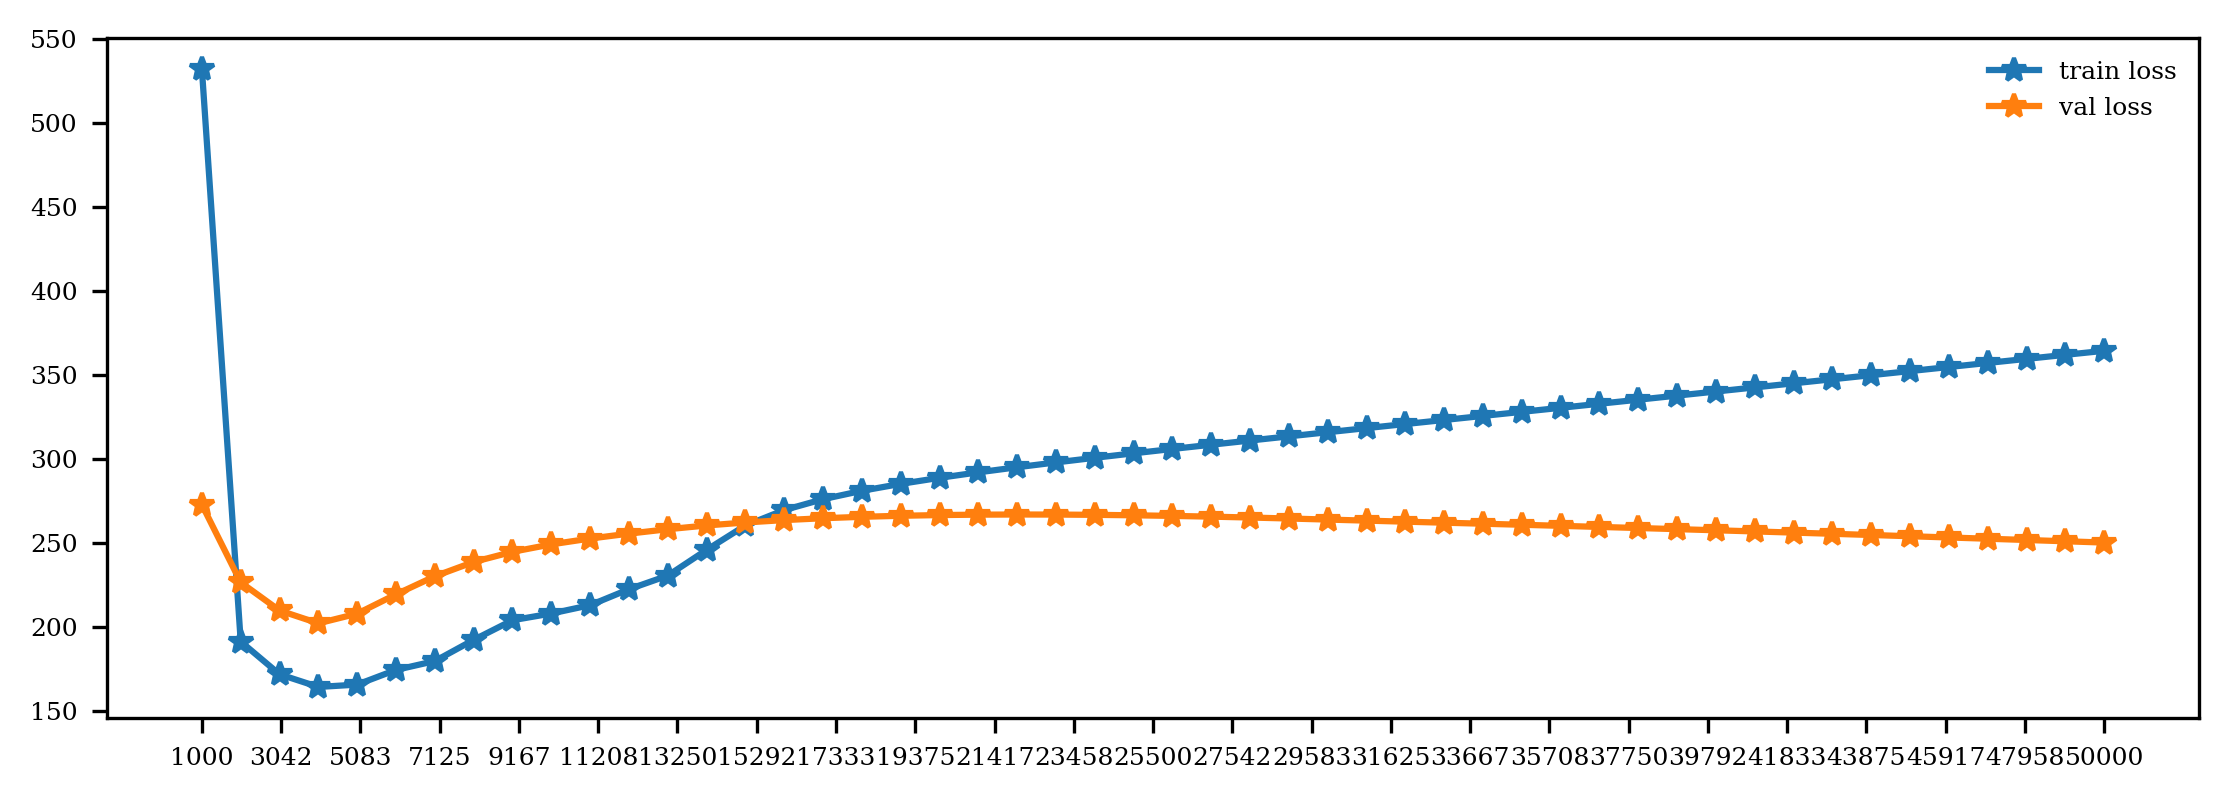

In [40]:
def losses_plot(x, train_loss, val_loss):
    fig, ax = plt.subplots()
    plt.plot(regularizers, train_losses, '-*', label='train loss')
    plt.plot(regularizers, val_losses, '-*', label='val loss')
    plt.xticks(np.linspace(regularizers[0], regularizers[-1], 25))
    plt.legend()
    plt.show()
    
losses_plot(regularizers, train_losses, val_losses)

Between 2nd and 4th are sweet spot. I will zoom into this

In [41]:
regularizers, train_losses, val_losses = train_and_plot(np.linspace(3e3, 5e3), 15)

  0%|          | 0/50 [00:00<?, ?it/s]

3000.0 171.65462386815005 209.6391920958572
3040.816326530612 170.50176225876757 209.39011508498913
3081.6326530612246 169.81414124533882 209.11623515187185
3122.4489795918366 168.88372223796276 208.8190928867744
3163.265306122449 168.0925444117461 208.5008454067844
3204.081632653061 167.6249949291365 208.16673558326156
3244.8979591836733 167.32370320576354 207.82114921557965
3285.714285714286 166.86302352450858 207.46597597654832
3326.530612244898 165.90726413203683 207.10329119799297
3367.3469387755104 164.74261838932497 206.73222369419278
3408.1632653061224 164.42323806027727 206.354595913276
3448.9795918367345 164.09021465872925 205.9739239786405
3489.795918367347 163.1712344910014 205.59227655830458
3530.612244897959 161.71487222868708 205.21383883702845
3571.4285714285716 160.25275381671005 204.84136564823694
3612.2448979591836 159.1678013690615 204.47897633622716
3653.0612244897957 158.4313283839648 204.12956529838132
3693.877551020408 158.30344742932527 203.79550685795263
3734.

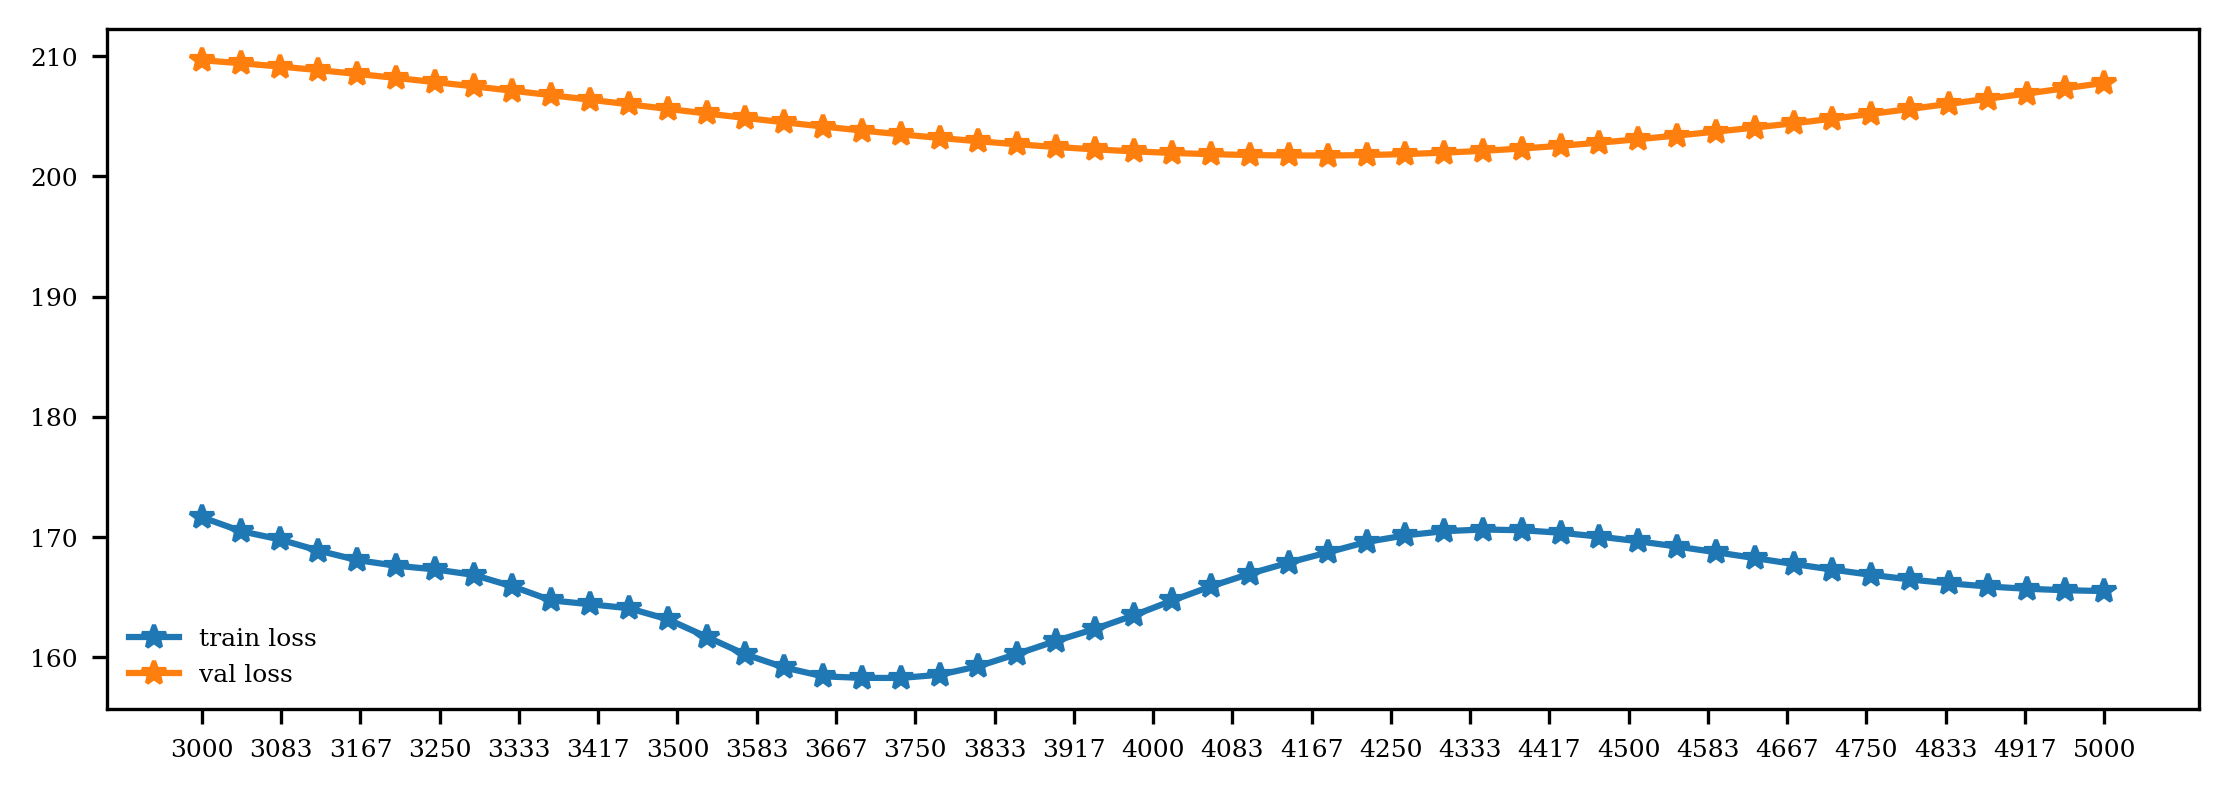

In [65]:
losses_plot(regularizers, train_losses, val_losses)

In [66]:
np.argmin(val_losses), np.min(val_losses), regularizers[np.argmin(val_losses)]

(29, 201.71884028821677, 4183.673469387755)

In [67]:
def plot_pred(groundtruth, prediction):
    plt.plot(range(groundtruth.shape[1]), groundtruth.mean(0))
    plt.plot(range(groundtruth.shape[1]), prediction.mean(0), alpha=0.5)
    plt.legend(["groundtruth", "prediction"])

## Plotting again with best params

In [68]:
rom = prepare_data_and_train(train_data, r=r, regularizer=regularizers[np.argmin(val_losses)])
prediction = rom.predict(train_data[:,-1], np.arange(start_prediction, end_prediction, DELTA_T), method='Radau')   # predict from the last column of train data        
predicted_p = post_process(prediction, max_ft['train_p'], min_ft['train_p'])
sanity_check = rom.predict(train_data[:,0], np.arange(DELTA_T, start_prediction- DELTA_T, DELTA_T))
sanity_check = post_process(sanity_check, max_ft['train_p'], min_ft['train_p'])

In [69]:
mse(sanity_check , tables['train_p'], squared=False), mse(tables['val_p'], predicted_p, squared=False)

(168.73394113815039, 201.71884028821677)

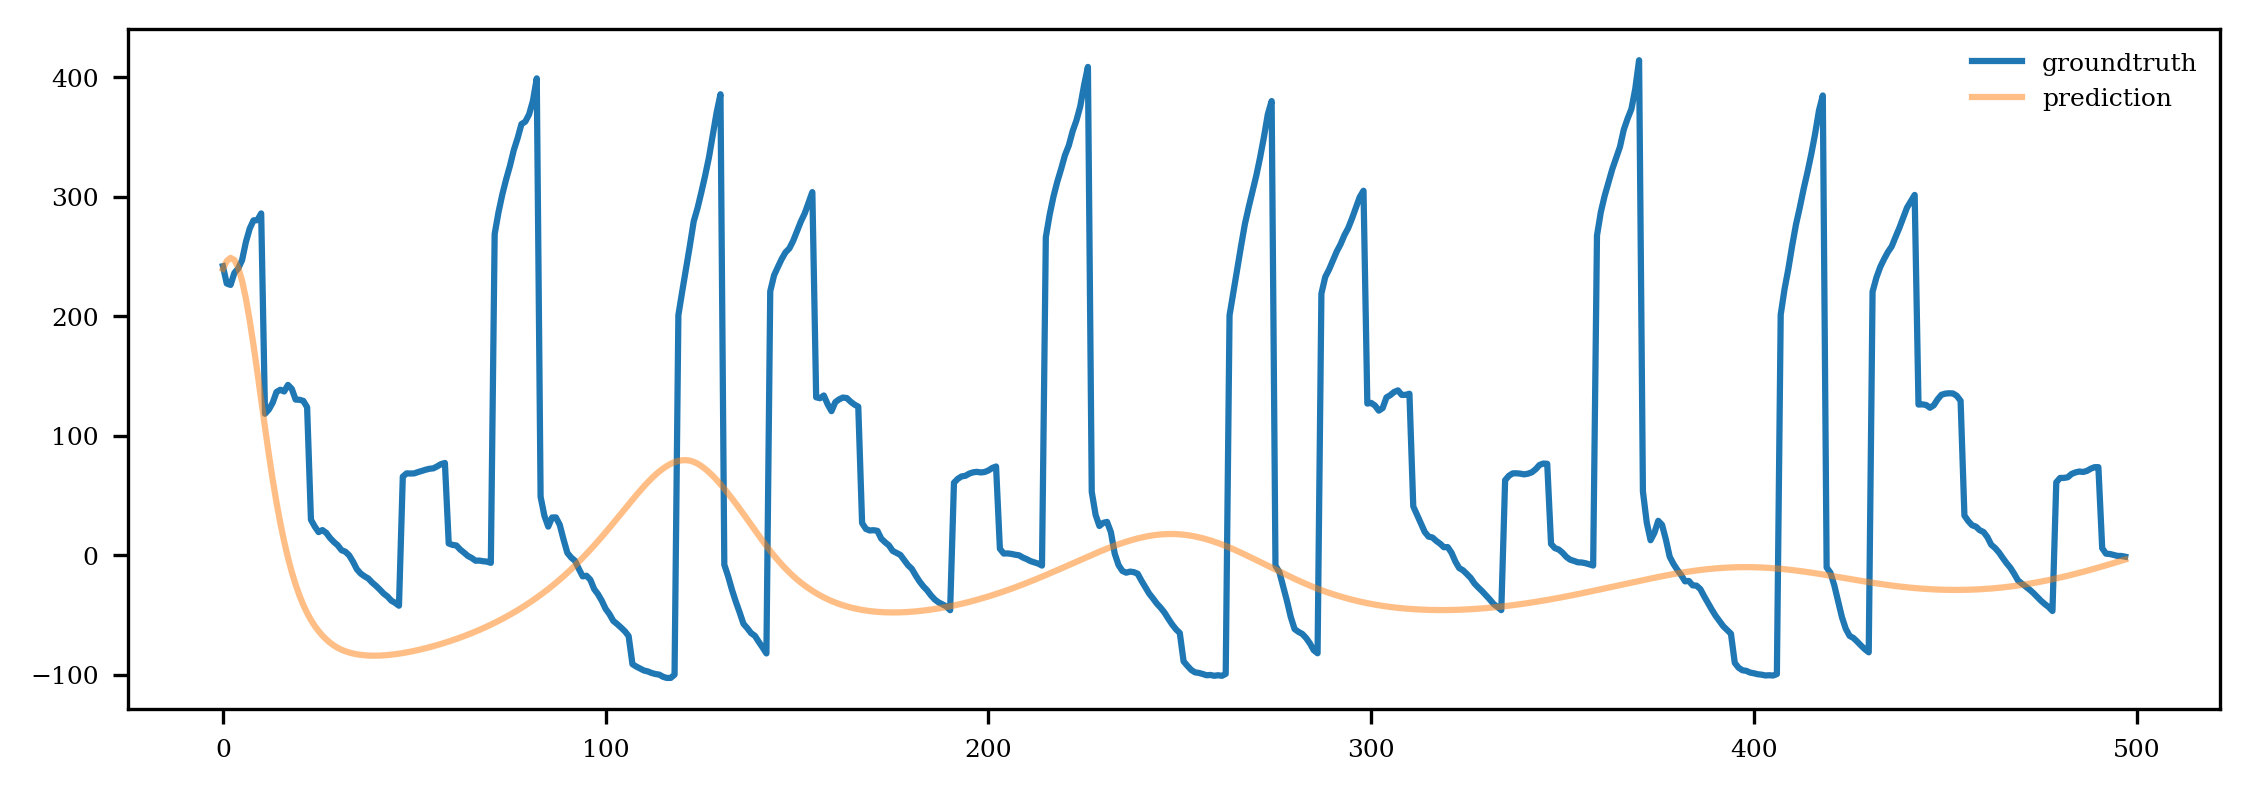

In [70]:
plot_pred(tables['train_p'], sanity_check)

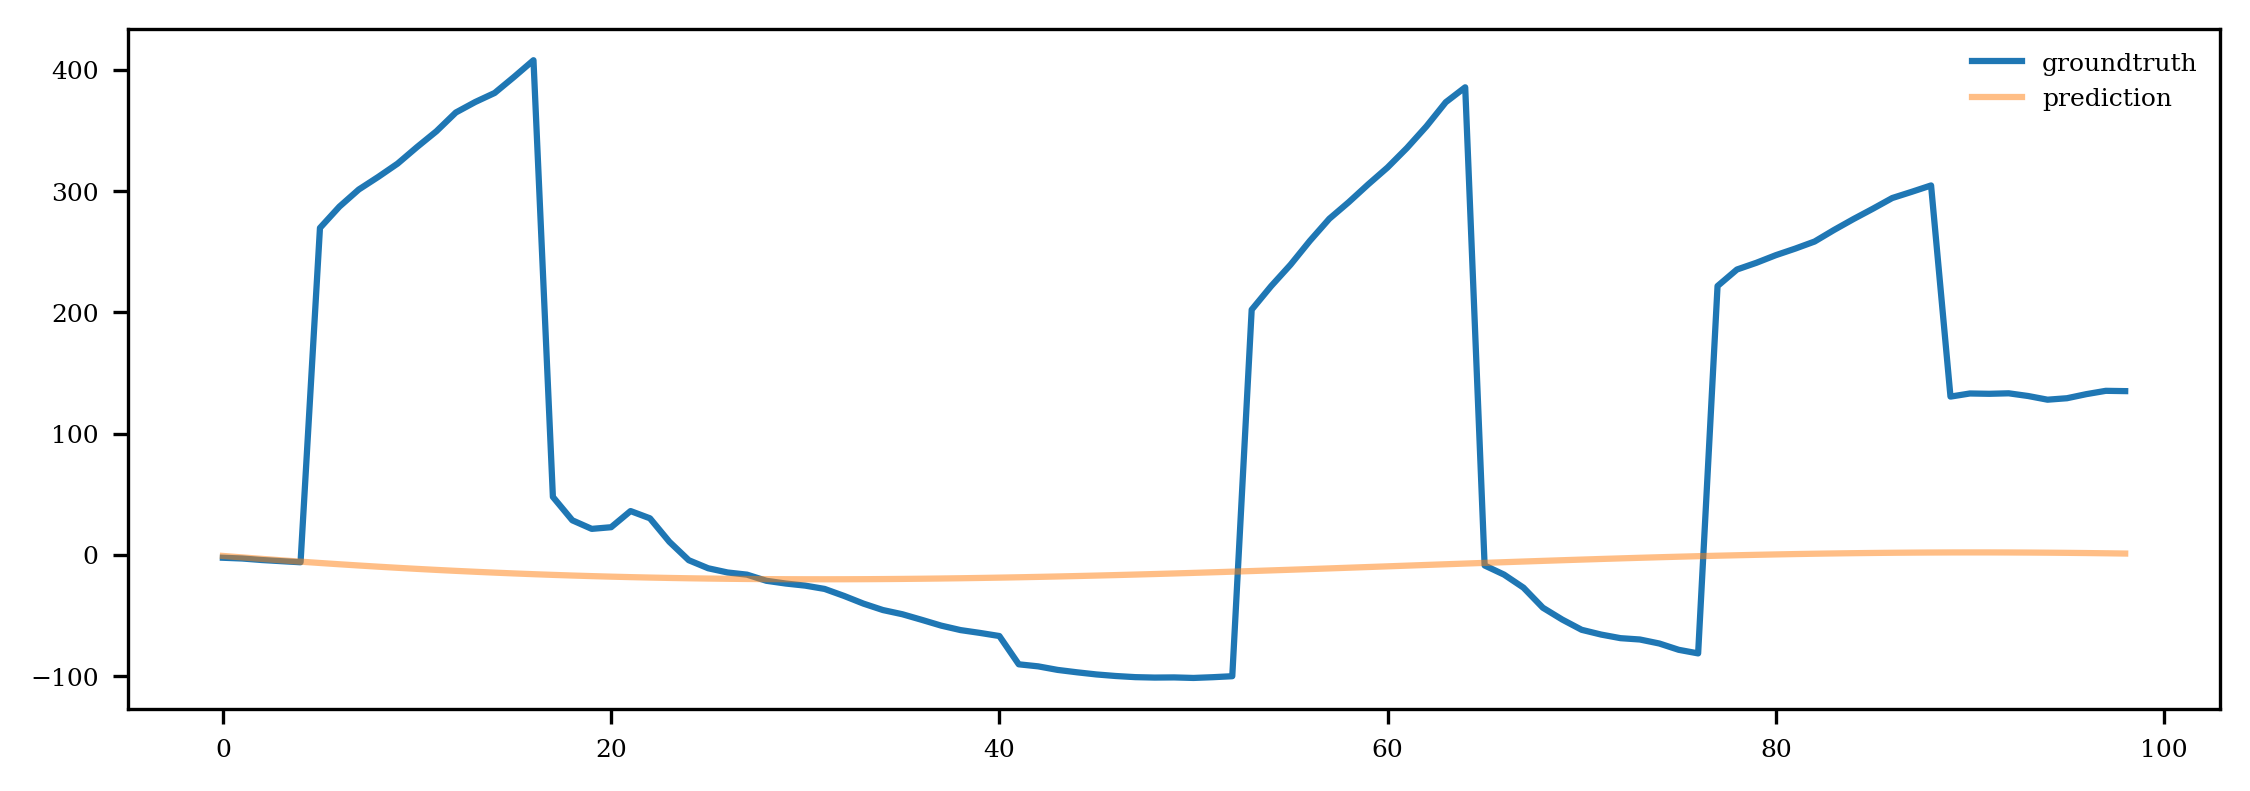

In [71]:
plot_pred(tables['val_p'], predicted_p)

## Train on train, val, and predict test

In [72]:
# Stack train, val and normalize
# concat train set with val set
train_data_dict = {}
for column in chosen_columns:
    train_data_dict[f'train_{column}'] = np.concatenate((tables[f'train_{column}'], tables[f'val_{column}']), axis=1)

In [73]:
# normalize each features 
normed_data, max_ft, min_ft = {}, {}, {}
for key in tables:
    if key.startswith('train'):
        normed_data[key], max_ft[key], min_ft[key] = normalize(tables[key])

In [74]:
# stack data
train_data = stack_data(normed_data, 'train')

After stacking shape:  (15164, 498)


In [75]:
for i, column in enumerate(chosen_columns):
    assert (train_data[i] == normed_data[f'train_{column}'][0]).all()

In [76]:
assert (train_data[0,:] == normed_data['train_p'][0,:]).all()
assert (train_data[1,:] == normed_data['train_U:2'][0,:]).all()

In [78]:
# train 
rom = prepare_data_and_train(train_data, r, regularizer=regularizers[np.argmin(val_losses)])

# predict
prediction = rom.predict(train_data[:,-1], np.arange(0.0598, 0.0999, 1e-4), method='Radau')   # predict from the last column of val data
predicted_p = post_process(prediction, max_ft['train_p'], min_ft['train_p'])

tmp = mse(predicted_p, tables['test_p'], squared=False)

In [79]:
tmp  # 

137.14877428798286

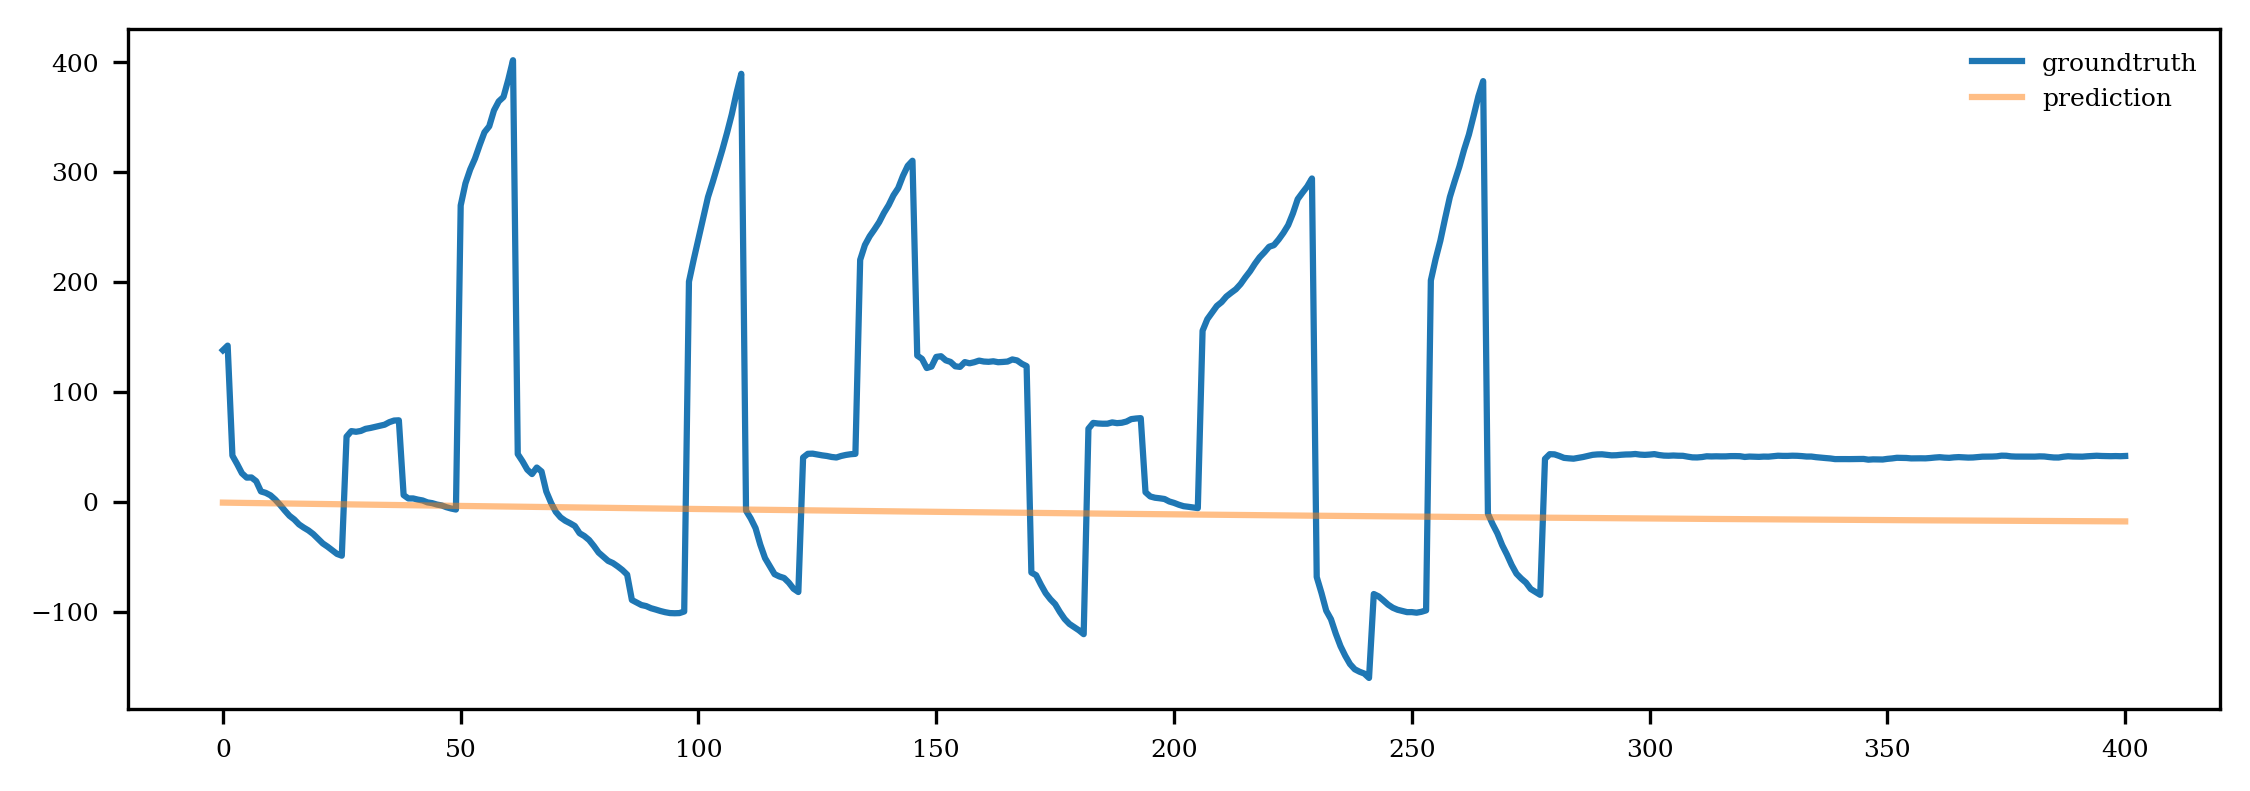

In [80]:
plot_pred(tables['test_p'], predicted_p)